__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display, display_html  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from scipy import stats  # statistical tests
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 3 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""
event_ranges = [(1162, 1400), (1958, 2080), (2596, 2890)]

CONDS = ["AVAS", "RadioTalk", "TaxiDriver"]

grp_cats = [
    "Buildings",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    "Inside Car",
    "Nature",
    "Roads",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette

colors = [next(palette) for i in range(3)]

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Read participants and questionnaires cleaned data__

In [3]:
parts = pd.read_csv("./participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)

quests = pd.read_csv("./questionnaires.csv", keep_default_na=False)
quests = quests.set_index("id")  # set uid column as index (remove default)

display(parts)
display(quests)

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire
id,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.610,13.740,2.359,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.037,0.674,25.421,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.037,33.134,0.786,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.824,18.607,2.845,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.225,26.994,0.262,No
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.300,32.160,0.000,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.674,15.462,5.054,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.797,3.370,11.718,No


,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,side,condition
id,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,Yes,80,58,more than 10 times,MSW,right,RadioTalk
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,No,0,5,once,MSW,left,RadioTalk
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,No,4,2,once,MSW,right,RadioTalk
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,No,3,1,less than 10 times,MSW,right,TaxiDriver
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,No,0,3,less than 10 times,MSW,right,RadioTalk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,No,0,25,once,BMBF,right,RadioTalk
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,Yes,99,9,less than 10 times,BMBF,right,TaxiDriver
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,No,39,0,never,BMBF,right,RadioTalk


Load the stored critical event frames

In [4]:
with open("gazes_and_hits-event_frames.json", "r") as file:
    ev_frames = json.load(file)

Plot events high alpha

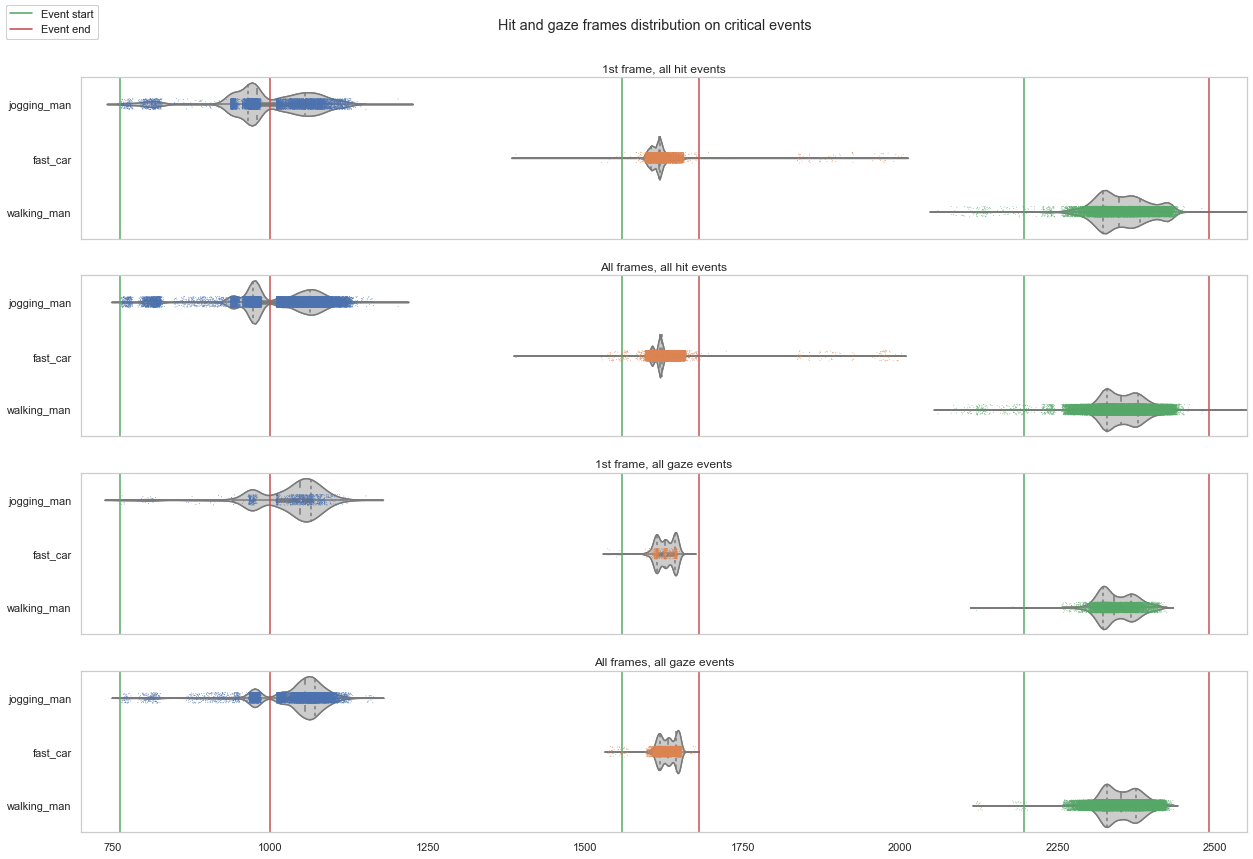

In [5]:
sns.set(rc={"figure.figsize": (17, 12)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(17, 12))
fig.suptitle("Hit and gaze frames distribution on critical events\n\n")
fig.tight_layout()

title_trans = {
    "h_start": "1st frame, all hit events",
    "g_start": "1st frame, all gaze events",
    "h_all": "All frames, all hit events",
    "g_all": "All frames, all gaze events",
}


def plot_event_frames(frames_dict, title, r, alpha=1):
    """
    Description.

    Parameters:
        frames_dict (dict): Blabla
    """
    # load dict into df (easier to plot using seaborn)
    df = pd.DataFrame.from_dict(
        data=frames_dict,
        orient="index",
    ).T
    # violinplot with quartiles
    ax = sns.violinplot(
        data=df,
        orient="h",
        inner="quartile",
        color=".8",
        scale="width",
        ax=axes[r],
    )
    # violinplot with boxplot
    ax = sns.violinplot(
        data=df, orient="h", color=".8", scale="width", ax=axes[r]
    )
    # categorical scatterplot
    ax = sns.stripplot(data=df, orient="h", alpha=alpha, ax=axes[r], size=0.8)

    # plot event ranges (vetical lines)
    for tup in event_ranges:
        axes[r].axvline(x=tup[0] - 400, color="g")  # plot start
        axes[r].axvline(x=tup[1] - 400, color="r")  # plot end
    ax.set_xlim(700, 2550)
    ax.grid(False)
    if r < 3:
        ax.xaxis.set_visible(False)
    ax.title.set_text(title_trans[title])
    # set custom legend for vertical lines
    start_line = Line2D([0], [0], color="g", label="Event start")
    end_line = Line2D([0], [0], color="r", label="Event end")
    fig.legend(handles=[start_line, end_line], loc="upper left")


for i, k in enumerate(ev_frames.keys()):
    plot_event_frames(ev_frames[k], k, i)

plt.show()

Plot events low alpha

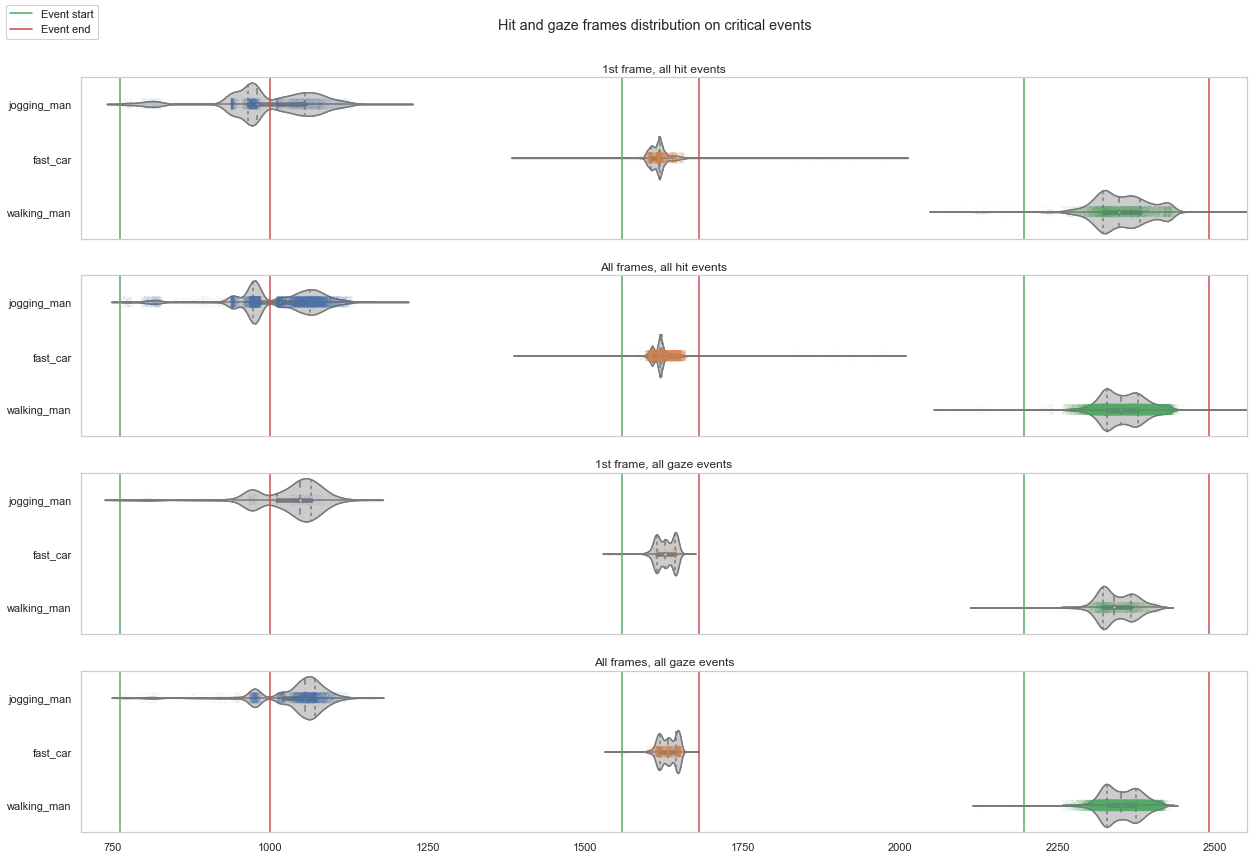

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(17, 12))
fig.suptitle("Hit and gaze frames distribution on critical events\n\n")
fig.tight_layout()

for i, k in enumerate(ev_frames.keys()):
    plot_event_frames(ev_frames[k], k, i, 0.1)

plt.show()

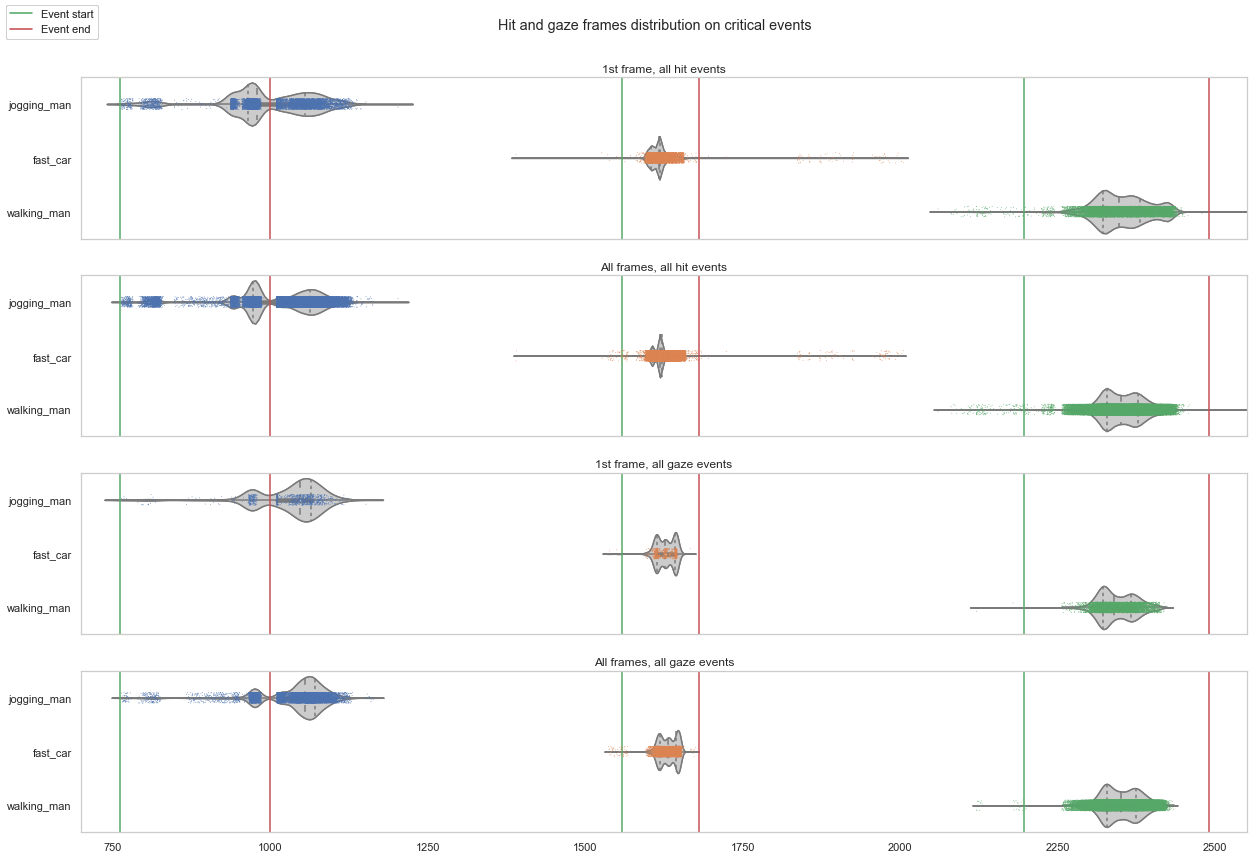

In [7]:
sns.set(rc={"figure.figsize": (17, 12)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(17, 12))
fig.suptitle("Hit and gaze frames distribution on critical events\n\n")
fig.tight_layout()

title_trans = {
    "h_start": "1st frame, all hit events",
    "g_start": "1st frame, all gaze events",
    "h_all": "All frames, all hit events",
    "g_all": "All frames, all gaze events",
}


def plot_event_frames(frames_dict, title, r, alpha=1):
    """
    Description.

    Parameters:
        frames_dict (dict): Blabla
    """
    # load dict into df (easier to plot using seaborn)
    df = pd.DataFrame.from_dict(
        data=frames_dict,
        orient="index",
    ).T
    # violinplot with quartiles
    ax = sns.violinplot(
        data=df,
        orient="h",
        inner="quartile",
        color=".8",
        scale="width",
        ax=axes[r],
    )
    # violinplot with boxplot
    ax = sns.violinplot(
        data=df, orient="h", color=".8", scale="width", ax=axes[r]
    )
    # categorical scatterplot
    ax = sns.stripplot(data=df, orient="h", alpha=alpha, ax=axes[r], size=0.8)

    # plot event ranges (vetical lines)
    for tup in event_ranges:
        axes[r].axvline(x=tup[0] - 400, color="g")  # plot start
        axes[r].axvline(x=tup[1] - 400, color="r")  # plot end
    ax.set_xlim(700, 2550)
    ax.grid(False)
    if r < 3:
        ax.xaxis.set_visible(False)
    ax.title.set_text(title_trans[title])
    # set custom legend for vertical lines
    start_line = Line2D([0], [0], color="g", label="Event start")
    end_line = Line2D([0], [0], color="r", label="Event end")
    fig.legend(handles=[start_line, end_line], loc="upper left")


for i, k in enumerate(ev_frames.keys()):
    plot_event_frames(ev_frames[k], k, i)

plt.show()

In [8]:
parts_evs = copy.deepcopy(parts)
parts_evs

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire
id,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.610,13.740,2.359,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.037,0.674,25.421,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.037,33.134,0.786,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.824,18.607,2.845,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.225,26.994,0.262,No
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.300,32.160,0.000,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.674,15.462,5.054,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.797,3.370,11.718,No


In [9]:
uids = parts_evs.index.tolist()
PATH_GAZE_FRAMES = "./data/processed/events/frames"

coll_gevs = {
    uid: {"jogging_man": None, "fast_car": None, "walking_man": None}
    for uid in uids
}

# participants progress bar
uids_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for uid in uids_pbar:
    try:
        with open(f"{PATH_GAZE_FRAMES}/{uid}.json", "r") as file:
            ev_frames = json.load(file)
            for obj in ev_frames.keys():
                coll_gevs[uid][obj] = len(ev_frames[obj]["g_start"])
    except:
        for obj in coll_gevs[uid].keys():
            coll_gevs[uid][obj] = 0

📄 0 of 24356 📂 participants processed:                                                                        …

In [10]:
test = pd.DataFrame(coll_gevs)
test = test.transpose()
for col in test.columns.tolist():
    parts_evs[col] = test[col]

parts_evs

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire,jogging_man,fast_car,walking_man
id,,,,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.610,13.740,2.359,No,0,0,0
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.037,0.674,25.421,No,0,0,0
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.037,33.134,0.786,No,0,0,0
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.824,18.607,2.845,No,0,1,0
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.225,26.994,0.262,No,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.300,32.160,0.000,No,0,0,0
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.674,15.462,5.054,No,0,0,0
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.797,3.370,11.718,No,0,0,0


In [11]:
cols = test.columns.tolist()
cols.append("condition")
cols.append("side")
display(parts_evs[cols].groupby(["condition"]).describe().transpose())

condition             AVAS  RadioTalk  TaxiDriver
jogging_man count 8251.000   7908.000    8197.000
            mean     0.042      0.041       0.044
            std      0.220      0.215       0.229
            min      0.000      0.000       0.000
            25%      0.000      0.000       0.000
            50%      0.000      0.000       0.000
            75%      0.000      0.000       0.000
            max      3.000      4.000       3.000
fast_car    count 8251.000   7908.000    8197.000
            mean     0.014      0.023       0.049
            std      0.122      0.154       0.220
            min      0.000      0.000       0.000
            25%      0.000      0.000       0.000
            50%      0.000      0.000       0.000
            75%      0.000      0.000       0.000
            max      2.000      2.000       2.000
walking_man count 8251.000   7908.000    8197.000
            mean     0.341      0.270       0.199
            std      0.526      0.479       0.446
            min      0.000      0.000       0.000
            25%      0.000      0.000       0.000
            50%      0.000      0.000       0.000
            75%      1.000      1.000       0.000
            max      4.000      3.000       3.000

In [12]:
parts_evs[cols]

,jogging_man,fast_car,walking_man,condition,side
id,,,,,
4f583872ffed48249874b00f3d389cfc,0,0,0,TaxiDriver,right
33d68ad55ef544fab9fd08108e3913ca,0,0,0,AVAS,right
8598a83e2af441b8bcd0ae5d84beb875,0,0,0,RadioTalk,right
37d7e67934974217830bb429bba7fd76,0,1,0,AVAS,left
42bac596059749b5b8e8e83ae61de9b4,0,0,0,TaxiDriver,right
...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,0,0,0,AVAS,right
611d35a7c3e940cc82495e53c2a8532d,0,0,0,TaxiDriver,right
3b6fda285d9e412eb081986b2f22a2e3,0,0,0,AVAS,left


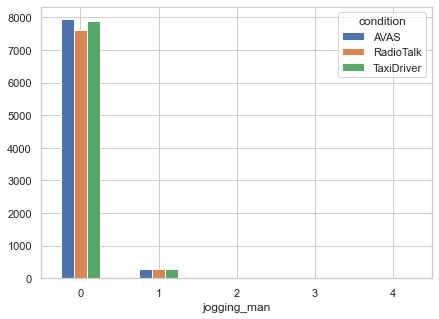

condition,AVAS,RadioTalk,TaxiDriver
jogging_man,,,
0,7938.000,7605.000,7877.000
1,284.000,283.000,285.000
2,26.000,18.000,31.000
3,3.000,1.000,4.000
4,NaN,1.000,NaN


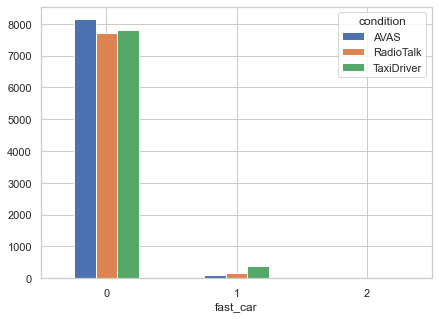

condition,AVAS,RadioTalk,TaxiDriver
fast_car,,,
0,8139,7728,7803
1,108,176,387
2,4,4,7


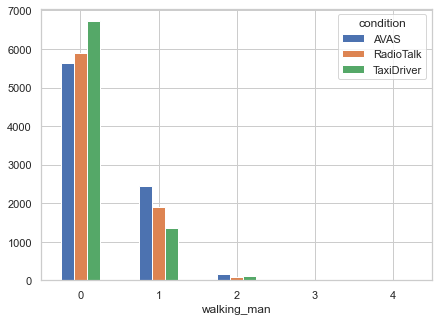

condition,AVAS,RadioTalk,TaxiDriver
walking_man,,,
0,5633.000,5891.000,6714.000
1,2447.000,1910.000,1354.000
2,152.000,97.000,113.000
3,17.000,10.000,16.000
4,2.000,NaN,NaN


In [13]:
cols = test.columns.tolist()
for col in cols:
    ax = (
        parts_evs.groupby(col)["condition"]
        .value_counts()
        .unstack()
        .plot.bar(figsize=(7, 5), rot=0)
    )
    plt.show()
    display(
        parts_evs.groupby("condition")[col]
        .value_counts()
        .unstack()
        .transpose()
    )

In [14]:
with open("gazes_and_hits-event_frames.json", "r") as file:
    ev_frames = json.load(file)

events = ev_frames["g_start"].keys()

for e in events:
    print(f"Event {e}: {len(ev_frames['g_start'][e])}")

Event jogging_man: 1030
Event fast_car: 701
Event walking_man: 6572


In [15]:
parts_evs[events].sum()

jogging_man    1030
fast_car        701
walking_man    6572
dtype: int64